In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

### Pose类介绍

`Pose`类用于表示二维平面中的位姿（位置和朝向）。它包含以下属性和方法：

#### 属性
- `x`: 表示位姿的x坐标。
- `y`: 表示位姿的y坐标。
- `theta`: 表示位姿的朝向角（弧度制）。通过setter方法，`theta`会被标准化到`[-π, π]`范围内。
- `ref`: 表示当前位姿的参考位姿（可选）。如果设置了参考位姿，可以通过递归方式计算绝对位姿。

#### 方法
- `__init__(self, x=0, y=0, theta=0, ref=None)`: 构造函数，用于初始化位姿的x、y、theta和参考位姿。
- `__repr__(self)`: 返回位姿的字符串表示，便于调试和打印。
- `theta`属性的getter和setter: 用于获取和设置`theta`，并确保`theta`始终在`[-π, π]`范围内。
- `abs_Pose(self)`: 计算当前位姿的绝对位姿。如果没有参考位姿，直接返回自身；如果有参考位姿，则递归计算参考位姿的绝对位置，并将当前相对位置转换为绝对位置。

In [58]:
class Pose:
    def __init__(self, x=0, y=0, theta=0, ref=None):
        self.x = x
        self.y = y
        self.theta = theta
        self.ref = ref

    def __repr__(self):
        return f"Pose(x={self.x}, y={self.y}, theta={self.theta}, ref={self.ref})"

    @property
    def theta(self):
        return self._theta

    @theta.setter
    def theta(self, value):
        self._theta = np.arctan2(np.sin(value), np.cos(value))  # 标准化到 [-pi, pi]
    
    def abs_Pose(self):
        if self.ref is None:
            # 如果没有参考点，直接返回当前位姿
            return self
        # 递归参考点转换，直到找到参考点退出
        ref_abs_pose = self.ref.abs_Pose()

        # 将相对位置转换为绝对位置
        cos_theta = np.cos(ref_abs_pose.theta)
        sin_theta = np.sin(ref_abs_pose.theta)

        # 计算绝对位置
        abs_x = ref_abs_pose.x + self.x * cos_theta - self.y * sin_theta
        abs_y = ref_abs_pose.y + self.x * sin_theta + self.y * cos_theta

        # 计算绝对朝向
        abs_theta = ref_abs_pose.theta + self.theta
        abs_theta = np.arctan2(np.sin(abs_theta), np.cos(abs_theta))

        return Pose(abs_x, abs_y, abs_theta)

#### 示例

In [59]:
# 创建一个绝对位姿
pose1 = Pose(x=1, y=2, theta=np.pi/2)

# 创建一个相对于pose1的位姿
pose2 = Pose(x=1, y=1, theta=np.pi/4, ref=pose1)

print(pose1) 
print(pose2) 
print(pose2.abs_Pose())  # 输出pose2的绝对位姿

Pose(x=1, y=2, theta=1.5707963267948966, ref=None)
Pose(x=1, y=1, theta=0.7853981633974483, ref=Pose(x=1, y=2, theta=1.5707963267948966, ref=None))
Pose(x=0.0, y=3.0, theta=2.356194490192345, ref=None)


### abs_to_rel

`abs_to_rel`函数用于将两个绝对位姿之间的关系转换为相对位姿。它的主要功能是计算一个位姿相对于另一个位姿的相对位置和朝向。

#### 参数
- `x_pose`: 参考位姿，类型为`Pose`。
- `y_pose`: 目标位姿，类型为`Pose`。

#### 返回值
返回一个新的`Pose`对象，表示`y`在`x`的坐标系下的相对位姿。

In [60]:
def abs_to_rel(x_pose, y_pose):
    x_tmp_pose = x_pose.abs_Pose()  # 确保y_pose是绝对位置
    y_tmp_pose = y_pose.abs_Pose()  # 确保y_pose是绝对位置
    # 计算相对位置
    dx = y_tmp_pose.x - x_tmp_pose.x
    dy = y_tmp_pose.y - x_tmp_pose.y

    # 计算相对于x坐标系的位置
    cos_theta = np.cos(x_tmp_pose.theta)
    sin_theta = np.sin(x_tmp_pose.theta)

    # 旋转变换到x的坐标系
    rel_x = dx * cos_theta + dy * sin_theta
    rel_y = -dx * sin_theta + dy * cos_theta

    # 计算相对朝向
    rel_theta = y_tmp_pose.theta - x_tmp_pose.theta
    rel_theta = np.arctan2(np.sin(rel_theta), np.cos(rel_theta))

    return Pose(rel_x, rel_y, rel_theta, ref=x_pose)

### CustomController类

`CustomController`类是一个自定义控制器，用于计算机器人从当前位置移动到目标位置所需的控制量。它的主要功能是根据**当前位姿(`robot_pose`)** 和 **目标位姿(`target_pose`)** 计算 **两个方向的线速度(`v_x, v_y`)** 和 **角速度(`v_theta`)**。

#### 定义
**机器人坐标系**: 以机器人为原点，以当前朝向为x轴正方向建立右手系。

#### 属性
- `v`: 参考速度，表示自身移动的基础速度。

#### 方法
- `__init__(self, v=1.0)`: 构造函数，用于初始化参考速度`v`。
- `calculate_control(self, robot_pose, target_pose)`: 计算控制量的方法。
    - **参数**:
        - `robot_pose`: 当前机器人的位姿，类型为`Pose`。
        - `target_pose`: 目标位姿，类型为`Pose`。
    - **返回值**:
        - 返回一个三元组`(v_x, v_y, v_theta)`，分别表示机器人在自身坐标系下的线速度和角速度。

**本部分应按需改动成适合具体应用的控制逻辑。**

**如果不能有横向速度（如智能车），可以将`v_y`设置为0。**

In [ ]:
class CustomController:
    def __init__(self, v=1.0):
        self.v = v  # 参考速度
    
    def calculate_control(self, robot_pose, target_pose):
        # 计算相对位置
        rel_pose = abs_to_rel(robot_pose, target_pose)
        
        # 距离 R
        R = np.sqrt(rel_pose.x**2 + rel_pose.y**2)
        if R < 0.01:  # 避免除零
            return 0.0, 0.0, 0.0
        
        # alpha: 当前朝向和到目标位置方向的夹角
        alpha = np.arctan2(rel_pose.y, rel_pose.x)
        
        # theta: 当前朝向和目标朝向的夹角
        theta = rel_pose.theta
        
        v_x = self.v * np.cos(alpha)
        v_y = self.v * np.sin(alpha)
        # v_y = 0.0                                  #如果不能有横向速度（如智能车）
        v_theta = self.v * theta * np.cos(alpha) / R # 示例，改成自己的逻辑
        
        return v_x, v_y, v_theta

### animated_track_simulation 函数

`animated_track_simulation` 是一个用于模拟机器人从起始位置移动到目标位置的动画函数。它通过控制器计算控制量，逐步更新机器人的位姿，并生成动画以可视化整个运动过程。

#### 参数
- `start_pose`: 起始位姿，类型为 `Pose`，表示机器人的初始位置和朝向。
- `target_pose`: 目标位姿，类型为 `Pose`，表示机器人需要到达的位置和朝向。
- `controller`: 控制器对象，类型为 `CustomController`，用于计算机器人运动的控制量。
- `max_steps`: 最大步数，表示模拟的最大迭代次数（默认值为 100）。
- `dt`: 时间步长，表示每一步的时间间隔（默认值为 0.01）。
- `track`: 布尔值，表示是否绘制机器人运动的轨迹（默认值为 `True`）。
- `display_vel`: 布尔值，表示是否显示机器人速度信息（默认值为 `False`）。
- `save_path`: 可选参数，字符串类型，表示保存动画的文件路径（默认值为 `None`）。
- `fps`: 帧率，表示动画的帧速率（默认值为 30）。
- `dpi`: 图像分辨率，表示动画的每英寸点数（默认值为 100）。
- `extra_args`: 可选参数，列表类型，表示传递给 FFmpeg 的额外参数（默认值为 `['-vcodec', 'libx264']`）。
- `show_html`: 布尔值，表示是否以 HTML 格式返回动画（默认值为 `True`）。(如果为 `False`，则返回静态图像, 如果为 `True` 生成可能较慢)。

#### 返回值
返回一个 HTML 动画对象，用于在 Jupyter Notebook 中展示机器人运动的动画。

#### 功能描述
1. **初始化**:
    - 设置起始位姿和目标位姿。
    - 初始化存储轨迹和速度数据的变量。
    - 创建绘图对象，设置坐标轴范围和目标点标记。

2. **运动模拟**:
    - 在每一步中，调用控制器计算控制量（线速度和角速度）。
    - 根据控制量更新机器人的位姿。
    - 检查是否到达目标位置，满足停止条件时结束模拟。

3. **动画生成**:
    - 动态绘制机器人的位置、朝向箭头和运动轨迹。
    - 可选显示速度信息，包括速度矢量箭头和速度文本。
    - 使用 `ArtistAnimation` 创建动画。

4. **保存动画**:
    - 如果提供了 `save_path`，则将动画保存为视频文件，使用 FFmpeg 编码器。

5. **返回动画**:
    - 将生成的动画转换为 HTML 格式，便于在 Jupyter Notebook 中展示。


In [62]:
def animated_track_simulation(start_pose, target_pose, controller, max_steps=100, dt=0.01, track=True, display_vel=False, save_path=None, fps=30, dpi=100, extra_args=['-vcodec', 'libx264'], show_html=True):
    # 初始化数据存储
    x_data, y_data, theta_data = [], [], []

    # 初始化当前位姿
    current_pose = Pose(start_pose.x, start_pose.y, start_pose.theta)

    # 创建动画图形
    fig, ax = plt.subplots()
    
    # 计算自适应坐标系范围
    # 预估轨迹范围，考虑起点、终点和可能的路径
    x_min = min(start_pose.x, target_pose.x) - 2
    x_max = max(start_pose.x, target_pose.x) + 2
    y_min = min(start_pose.y, target_pose.y) - 2
    y_max = max(start_pose.y, target_pose.y) + 2
    
    # 确保坐标轴范围至少有一定大小
    x_range = max(x_max - x_min, 4)
    y_range = max(y_max - y_min, 4)
    
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    ax.set_xlim(x_center - x_range/2, x_center + x_range/2)
    ax.set_ylim(y_center - y_range/2, y_center + y_range/2)
    ax.set_aspect('equal')

    # 绘制目标点和目标朝向箭头
    ax.plot(target_pose.x, target_pose.y, 'ro', markersize=8, label='Target')
    arrow_length = 0.5
    ax.arrow(target_pose.x, target_pose.y, 
             arrow_length * np.cos(target_pose.theta), 
             arrow_length * np.sin(target_pose.theta),
             head_width=0.2, head_length=0.1, fc='red', ec='red')
    robot_arrow = ax.annotate('', xy=(0, 0), xytext=(0, 0),
                             arrowprops=dict(arrowstyle='->', color='blue', lw=2))

    # 速度显示（文本和矢量）
    if display_vel:
        vel_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        # 速度矢量箭头
        vel_arrow = ax.annotate('', xy=(0, 0), xytext=(0, 0),
                               arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))

    # 停止条件阈值
    position_threshold = 0.1
    angle_threshold = 0.1
    target_reached = False

    # 预先计算所有帧的数据
    frames_data = []
    
    for frame in range(max_steps):
        # 如果已经到达目标，停止计算
        if target_reached:
            break
            
        # 检查是否到达目标
        distance = np.sqrt((current_pose.x - target_pose.x)**2 + 
                          (current_pose.y - target_pose.y)**2)
        angle_diff = abs(current_pose.theta - target_pose.theta)
        angle_diff = min(angle_diff, 2*np.pi - angle_diff)  # 处理角度差的周期性
        
        if distance < position_threshold and angle_diff < angle_threshold:
            target_reached = True
            break
        
        # 计算控制量
        v_x, v_y, v_theta = controller.calculate_control(current_pose, target_pose)

        # 更新位姿 - 考虑机器人坐标系
        cos_theta = np.cos(current_pose.theta)
        sin_theta = np.sin(current_pose.theta)
        
        # 将机器人坐标系的速度转换为世界坐标系
        world_vx = v_x * cos_theta - v_y * sin_theta
        world_vy = v_x * sin_theta + v_y * cos_theta
        
        current_pose.x += world_vx * dt
        current_pose.y += world_vy * dt
        current_pose.theta += v_theta * dt

        # 存储数据
        x_data.append(current_pose.x)
        y_data.append(current_pose.y)
        theta_data.append(current_pose.theta)
        
        # 存储当前帧数据
        frame_data = {
            'pose': Pose(current_pose.x, current_pose.y, current_pose.theta),
            'velocities': (v_x, v_y, v_theta),
            'world_velocities': (world_vx, world_vy),
            'trajectory': (list(x_data), list(y_data))
        }
        frames_data.append(frame_data)
    
    # 动态调整坐标系范围
    if x_data and y_data:
        all_x = x_data + [target_pose.x]
        all_y = y_data + [target_pose.y]
        
        x_min_new = min(all_x) - 1
        x_max_new = max(all_x) + 1
        y_min_new = min(all_y) - 1
        y_max_new = max(all_y) + 1
        
        ax.set_xlim(x_min_new, x_max_new)
        ax.set_ylim(y_min_new, y_max_new)
    
    # 创建所有帧的艺术家对象
    artists = []
    
    for i, frame_data in enumerate(frames_data):
        frame_artists = []
        
        pose = frame_data['pose']
        v_x, v_y, v_theta = frame_data['velocities']
        world_vx, world_vy = frame_data['world_velocities']
        traj_x, traj_y = frame_data['trajectory']
        
        # 机器人位置
        robot_point = ax.plot(pose.x, pose.y, 'bo', markersize=6)[0]
        frame_artists.append(robot_point)
        
        # 机器人朝向箭头
        arrow_end_x = pose.x + arrow_length * np.cos(pose.theta)
        arrow_end_y = pose.y + arrow_length * np.sin(pose.theta)
        robot_arrow = ax.annotate('', xy=(arrow_end_x, arrow_end_y), xytext=(pose.x, pose.y),
                                 arrowprops=dict(arrowstyle='->', color='blue', lw=2))
        frame_artists.append(robot_arrow)
        
        # 轨迹
        if track:
            trajectory_line = ax.plot(traj_x, traj_y, 'b-', alpha=0.5)[0]
            frame_artists.append(trajectory_line)
        
        # 速度显示
        if display_vel:
            # 速度文本
            if target_reached and i == len(frames_data) - 1:
                vel_text = ax.text(0.02, 0.98, 'Target Reached!\nvx: 0.00\nvy: 0.00\nvθ: 0.00', 
                                 transform=ax.transAxes, verticalalignment='top',
                                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            else:
                vel_text = ax.text(0.02, 0.98, f'vx: {v_x:.2f}\nvy: {v_y:.2f}\nvθ: {v_theta:.2f}', 
                                 transform=ax.transAxes, verticalalignment='top',
                                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            frame_artists.append(vel_text)
            
            # 速度矢量箭头
            vel_scale = 1.0
            vel_end_x = pose.x + world_vx * vel_scale
            vel_end_y = pose.y + world_vy * vel_scale
            vel_arrow = ax.annotate('', xy=(vel_end_x, vel_end_y), xytext=(pose.x, pose.y),
                                   arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))
            frame_artists.append(vel_arrow)
        
        artists.append(frame_artists)
    
    # 使用ArtistAnimation创建动画
    ani = ArtistAnimation(fig, artists, interval=dt * 1000, blit=False, repeat=False)
    if save_path:
        ani.save(save_path, writer='ffmpeg', fps=fps, dpi=dpi, extra_args=extra_args)
    plt.legend()
    if show_html:
        # For Jupyter, we need to return the animation as HTML
        html_animation = HTML(ani.to_jshtml())
        plt.close(fig)
    else:
        html_animation = None
    return html_animation

### 示例

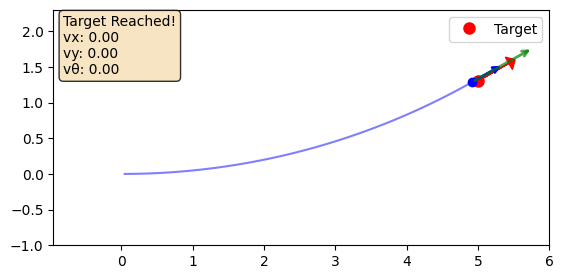

In [ ]:
start_pose = Pose(0, 0, 0) # 初始位姿
target_pose = Pose(5, 5, np.pi / 4) # 目标位姿
# 注意：如果需要使用相对位姿，请确保target_pose的ref属性正确设置
controller = CustomController(v=1.0) # 定义控制器类
animated_track_simulation(start_pose, target_pose, controller, max_steps=200, dt=0.05, track=True, display_vel=True, save_path='track_simulation.mp4', fps=60, dpi=100, extra_args=['-vcodec', 'libx264'], show_html=False)